In [ ]:
!pip install numpy matplotlib librosa soundfile noisereduce openai-whisper torch


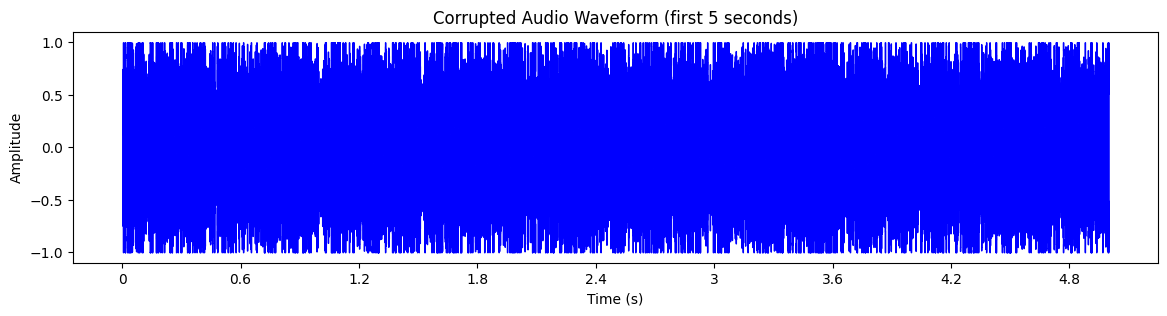

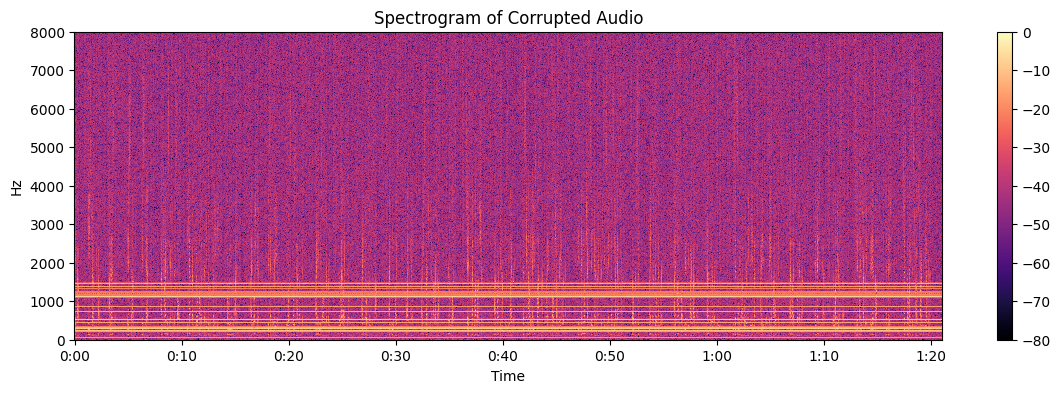

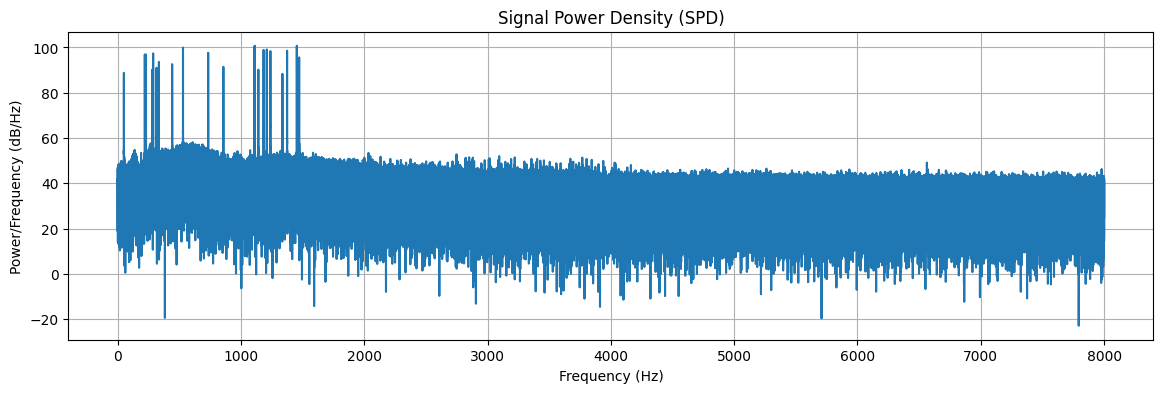

Estimated raw SNR: 9.76 dB


In [41]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

audio_path = "final_noise_audio.wav"
y, sr = librosa.load(audio_path, sr=None)

# --- Waveform plot (first 5s) ---
plt.figure(figsize=(14, 3))
librosa.display.waveshow(y[:sr * 5], sr=sr, color="blue")
plt.title('Corrupted Audio Waveform (first 5 seconds)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# --- Spectrogram (STFT) ---
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram of Corrupted Audio")
plt.show()

# --- Signal Power Density (SPD) ---
def compute_spd(signal, sr):
    psd = np.abs(np.fft.rfft(signal))**2
    freqs = np.fft.rfftfreq(len(signal), d=1/sr)
    return freqs, psd

freqs, psd = compute_spd(y, sr)
plt.figure(figsize=(14, 4))
plt.plot(freqs, 10 * np.log10(psd + 1e-20))  # add epsilon for log stability
plt.title('Signal Power Density (SPD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()

# --- Signal-to-Noise Ratio estimation ---
def estimate_snr(signal):
    rms_signal = np.sqrt(np.mean(signal**2))
    noise_est = np.percentile(np.abs(signal), 25)
    return 20 * np.log10(rms_signal / noise_est)

snr = estimate_snr(y)
print(f"Estimated raw SNR: {snr:.2f} dB")


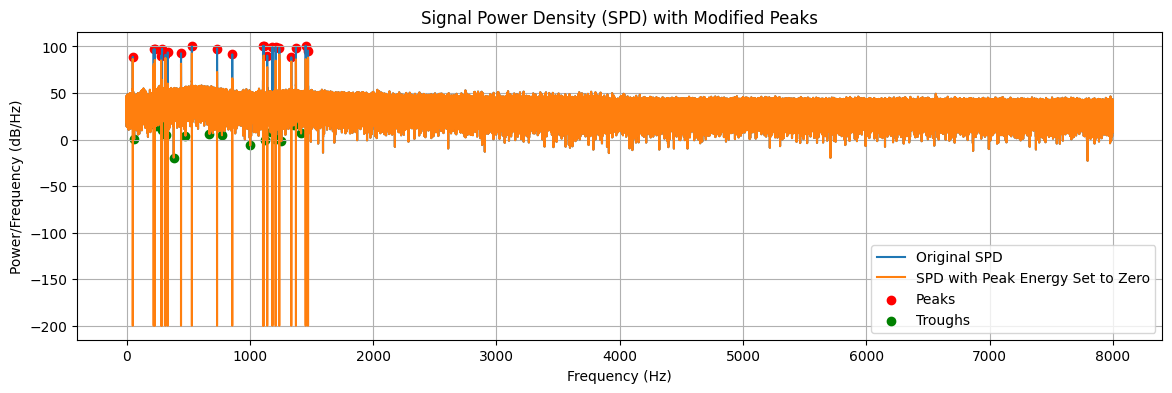

In [42]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import librosa

audio_path = "final_noise_audio.wav"
y, sr = librosa.load(audio_path, sr=None)

# --- Signal Power Density (SPD) ---
def compute_spd(signal, sr):
    psd = np.abs(np.fft.rfft(signal))**2
    freqs = np.fft.rfftfreq(len(signal), d=1/sr)
    return freqs, psd

freqs, psd = compute_spd(y, sr)

# --- Find peaks and troughs ---
peaks, _ = find_peaks(psd, height=np.max(psd)*0.05, distance=100)
troughs, _ = find_peaks(-psd, prominence=0.01*np.max(psd), distance=100)

# --- Set energy at detected peaks to zero ---
psd_modified = psd.copy()
psd_modified[peaks] = 0

# --- Plot original and modified SPD ---
plt.figure(figsize=(14, 4))
plt.plot(freqs, 10 * np.log10(psd + 1e-20), label='Original SPD')
plt.plot(freqs, 10 * np.log10(psd_modified + 1e-20), label='SPD with Peak Energy Set to Zero')
plt.scatter(freqs[peaks], 10 * np.log10(psd[peaks] + 1e-20), color='red', label='Peaks')
plt.scatter(freqs[troughs], 10 * np.log10(psd[troughs] + 1e-20), color='green', label='Troughs')
plt.title('Signal Power Density (SPD) with Modified Peaks')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
import noisereduce as nr

# Optionally, estimate noise from the first N seconds, e.g., first 0.5 sec
noise_sample = y[:int(sr * 10)]

# Reduce noise
y_denoised = nr.reduce_noise(y=y, sr=sr, y_noise=noise_sample)

# Save restored file
clean_path = "restored_audio.wav"
sf.write(clean_path, y_denoised, sr)


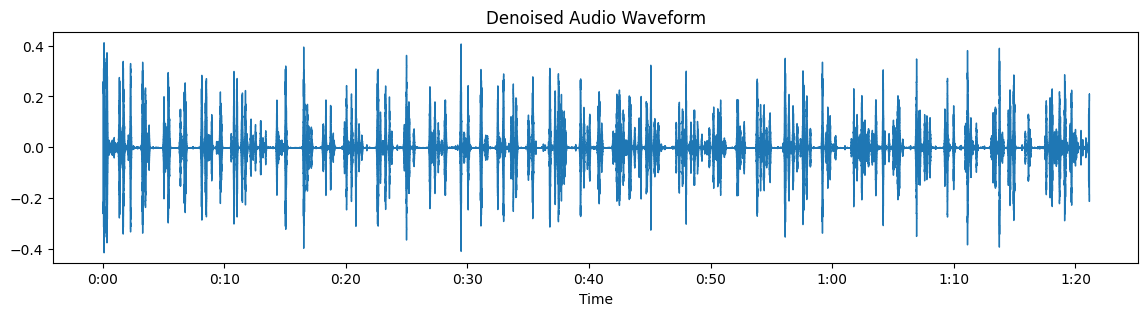

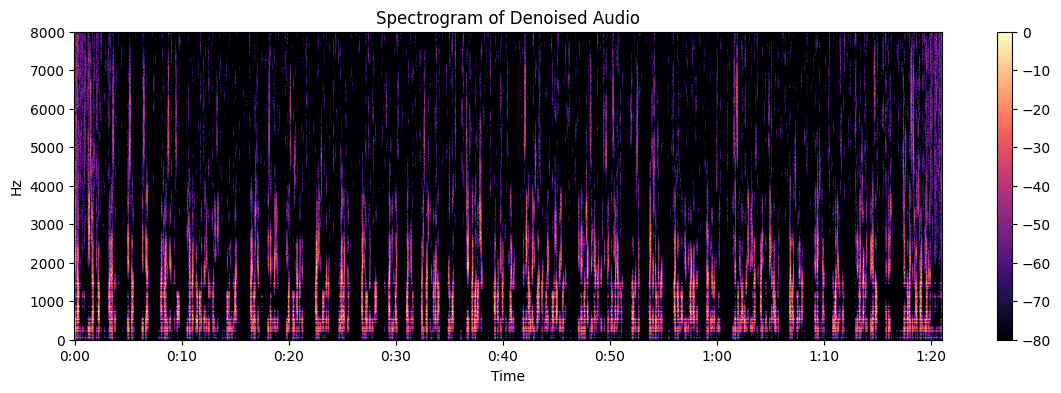

Estimated denoised SNR: 50.19 dB


In [48]:
# Waveform/Spectrogram after denoising
plt.figure(figsize=(14,3))
librosa.display.waveshow(y_denoised, sr=sr)
plt.title('Denoised Audio Waveform')
plt.show()

S_clean = librosa.stft(y_denoised)
S_clean_db = librosa.amplitude_to_db(np.abs(S_clean), ref=np.max)
plt.figure(figsize=(14,4))
librosa.display.specshow(S_clean_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram of Denoised Audio")
plt.show()

clean_snr = estimate_snr(y_denoised)
print(f"Estimated denoised SNR: {clean_snr:.2f} dB")


In [49]:
import whisper

# Load Whisper model (use "base" or "small" for speed, "large" for accuracy)
model = whisper.load_model("base")

# Transcribe
result = model.transcribe(clean_path)
print("Decoded message:\n", result["text"])


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Decoded message:
  He's just a healthy, honest look. His gun is dead. I tried to see him to be solved. He can't write to Bill Paul, if that new group was bloody deep. Probably he was alive. I approached him. He's head in the radio. He wants to post half my death. I think he's well-inverver. The red light's milk. I didn't know it was like this long. I can even write. I can't look. I just brushed him. I wrote a real blood. Shit, I blood, I'm sure. I've heard 300 games of you library. I was saying I'll leave a useless glass. I can go next to the wall or shop very hard. We pen one check, Zin can and I, 3-6 min. They'll see my down corner. So, versus if the late 1st of November. I talked about you 3-5 months ago. Half of November is a week. He said something about a quarter of an acre in the last month. I think it's the same thing I hope for. I will explore that round. And then he's the heaven. We want to hear them. So, he finds a referee to get solved. And finish. Just a little more, I was

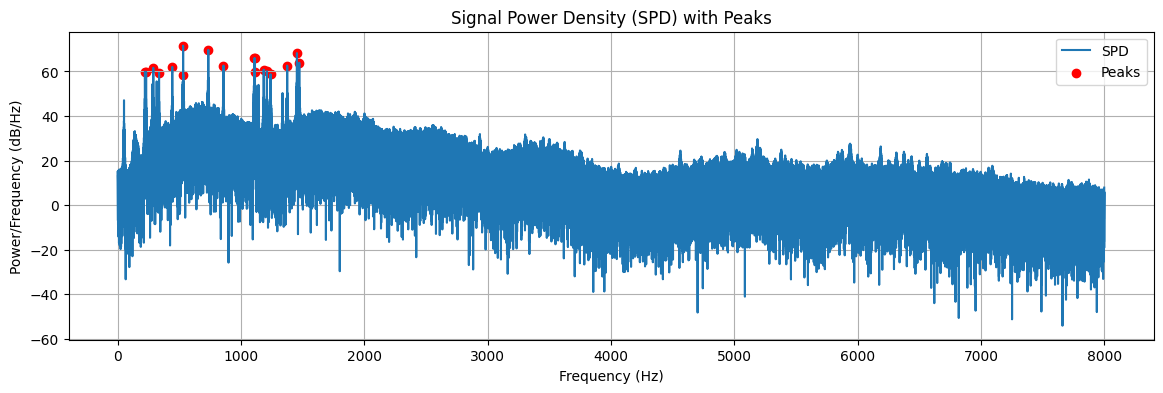

In [50]:
def compute_spd(signal, sr):
    psd = np.abs(np.fft.rfft(signal))**2
    freqs = np.fft.rfftfreq(len(signal), d=1/sr)
    return freqs, psd

freqs, psd = compute_spd(y_denoised, sr)

# --- Find and mark peaks in SPD ---
peaks, _ = find_peaks(psd, height=np.max(psd)*0.05) # Show peaks >10% of max for clarity

plt.figure(figsize=(14, 4))
plt.plot(freqs, 10 * np.log10(psd + 1e-20), label='SPD')
plt.scatter(freqs[peaks], 10 * np.log10(psd[peaks] + 1e-20), color='red', label='Peaks')
plt.title('Signal Power Density (SPD) with Peaks')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True)
plt.show()

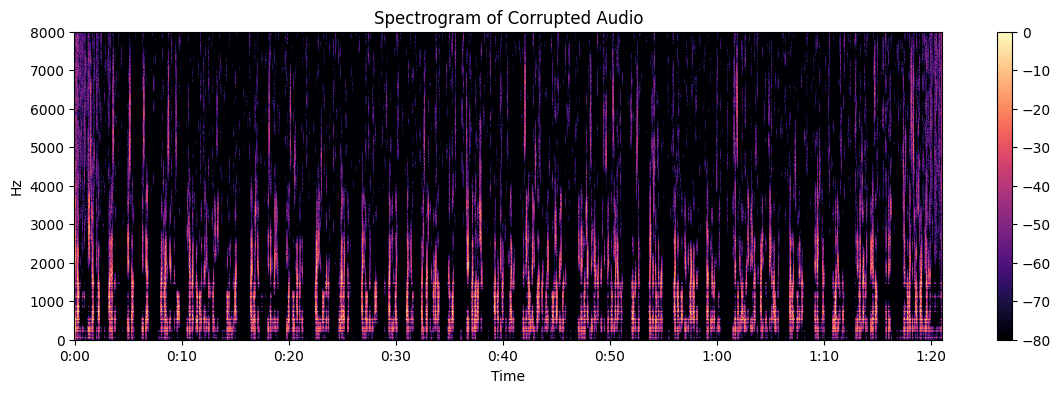

In [51]:
# --- Spectrogram (STFT) ---
S = librosa.stft(y_denoised)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram")
plt.show()